## 加载 MNIST 数据集

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data('mnist/mnist.npz')

Using TensorFlow backend.


In [3]:
print(x_train.shape, type(x_train))
print(y_train.shape, type(y_train))

(60000, 28, 28) <class 'numpy.ndarray'>
(60000,) <class 'numpy.ndarray'>


## 数据处理：规范化

In [4]:
# 将图像本身从[28,28]转换为[784,]
X_train = x_train.reshape(60000, 784)
X_test = x_test.reshape(10000, 784)
print(X_train.shape, type(X_train))
print(X_test.shape, type(X_test))

(60000, 784) <class 'numpy.ndarray'>
(10000, 784) <class 'numpy.ndarray'>


In [5]:
# 将数据类型转换为float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# 数据归一化
X_train /= 255
X_test /= 255

## 统计训练数据中各标签数量

In [6]:
import numpy as np
import matplotlib.pyplot as plt

label, count = np.unique(y_train, return_counts=True)
print(label, count)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


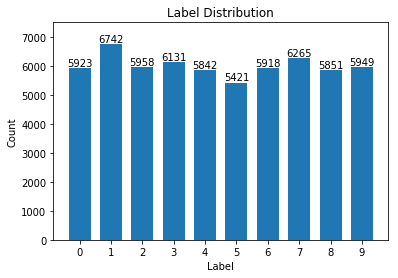

In [7]:
fig = plt.figure()
plt.bar(label, count, width = 0.7, align='center')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(label)
plt.ylim(0,7500)

for a,b in zip(label, count):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)

plt.show()

## 数据处理：one-hot 编码

### 几种编码方式的对比

| Binary | Gray code | One-hot  |
| ------ | --------- | -------- |
| 000    | 000       | 00000001 |
| 001    | 001       | 00000010 |
| 010    | 011       | 00000100 |
| 011    | 010       | 00001000 |
| 100    | 110       | 00010000 |
| 101    | 111       | 00100000 |
| 110    | 101       | 01000000 |
| 111    | 100       | 10000000 |

### one-hot 应用
![](https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2018/01/one-hot-word-embedding-vectors.png)

In [8]:
from keras.utils import np_utils

n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)
Y_test = np_utils.to_categorical(y_test, n_classes)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [9]:
print(y_train[0])
print(Y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 使用 Keras sequential model 定义神经网络

### softmax 网络层

![](https://developers.google.com/machine-learning/crash-course/images/SoftmaxLayer.svg)

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


## 编译模型

[model.compile()](https://keras.io/models/sequential/#compile)

```python
compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
```

In [11]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## 训练模型，并将指标保存到 history 中

[model.fit()](https://keras.io/models/sequential/#fit)

```python
fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
```

In [12]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=128,
                    epochs=5,
                    verbose=2,
                    validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 14s - loss: 0.2190 - acc: 0.9358 - val_loss: 0.1106 - val_acc: 0.9665
Epoch 2/5
 - 12s - loss: 0.0793 - acc: 0.9760 - val_loss: 0.0814 - val_acc: 0.9757
Epoch 3/5
 - 12s - loss: 0.0508 - acc: 0.9838 - val_loss: 0.0635 - val_acc: 0.9805
Epoch 4/5
 - 12s - loss: 0.0335 - acc: 0.9893 - val_loss: 0.0758 - val_acc: 0.9777
Epoch 5/5
 - 13s - loss: 0.0258 - acc: 0.9915 - val_loss: 0.0783 - val_acc: 0.9792


## 可视化指标

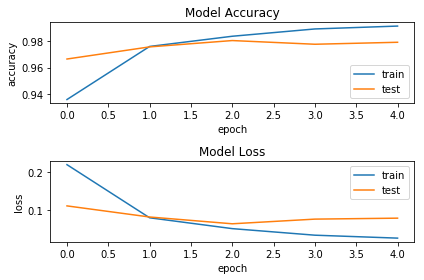

In [13]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

plt.show()

## 保存模型

[model.save()](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)

You can use `model.save(filepath)` to save a Keras model into a single **HDF5 file** which will contain:

- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

You can then use `keras.models.load_model(filepath)` to reinstantiate your model. load_model will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [14]:
import os
import tensorflow.gfile as gfile

save_dir = "./mnist/model/"

if gfile.Exists(save_dir):
    gfile.DeleteRecursively(save_dir)
gfile.MakeDirs(save_dir)

model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./mnist/model/keras_mnist.h5 


## 加载模型

In [15]:
from keras.models import load_model

mnist_model = load_model(model_path)

## 统计模型在测试集上的分类结果

In [16]:
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)
    
print("Test Loss: {}".format(loss_and_metrics[0]))
print("Test Accuracy: {}%".format(loss_and_metrics[1]*100))

predicted_classes = mnist_model.predict_classes(X_test)

correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print("Classified correctly count: {}".format(len(correct_indices)))
print("Classified incorrectly count: {}".format(len(incorrect_indices)))

Test Loss: 0.07832175676832849
Test Accuracy: 97.92%
Classified correctly count: 9792
Classified incorrectly count: 208
